# Создание трансформера с нуля

**Цель домашнего задания**: создать собственный трансформер с нуля, реализуя все основные блоки самостоятельно.

В теме №1 вы познакомились с архитектурой ***Трансформер*** и основными его составляющими. Давайте попробуем теперь их реализовать.

Напомним еще раз, как выглядит модель типа трансформер:

<img src='https://deeprevision.github.io/posts/001-transformer/transformer.png' align="center" height=400, width=600>

### Multi-head attention блок

Первый блок, который мы реализуем, является самой важной частью трансформера и называется Multi-head Attention.

Ниже представлен класс для реализации этого блока. Вам нужно дописать недостающие части кода, основываясь на теоретических знаниях.

Напомним про центральную часть данного механизма: запрос, ключ, значение. **Запрос** — это информация, которую вы пытаетесь сопоставить. **Ключи** и **значения** — это сохраненная информация. Именно в этом и заключается суть механизма внимания: анализ различных частей данных и их объединение для получения синтезированного ответа на ваш запрос.

<img src='https://miro.medium.com/v2/resize:fit:1400/1*dSwckeG028obZPWafgJrmw.png' align="center" height=200, width=500>

При обработке входящей последовательности необходимо учитывать несколько факторов.

Во-первых, специальные токены заполнения, используемые для выравнивания всех последовательностей в батче до одного размера, должны игнорироваться нашей моделью.

Во-вторых, в процессе обучения надо использовать маску, чтобы гарантировать, что модель на каждом временном шаге может видеть только информацию из прошлого.

In [1]:
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=256, num_heads=4):
        """
        Инициализация MultiHeadAttention.

        Аргументы:
            hidden_dim: Размерность входных данных.
            num_heads: Количество голов внимания, на которое делится вход.
        """
        super(MultiHeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        assert hidden_dim % num_heads == 0, "Размерность скрытого слоя должна быть делимой на количество голов"
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False) # матрица значения (Value)
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False)# Ваш код здесь (матрица ключа (Key))
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False)# Ваш код здесь (матрица запроса (Query))
        self.Wo = nn.Linear(hidden_dim, hidden_dim, bias=False)# Ваш код здесь (выходной слой)


    def check_sdpa_inputs(self, x):
        """
        Проверка входных данных для scaled_dot_product_attention.

        Аргументы:
            x: Входной тензор.
        """
        assert x.size(1) == self.num_heads, f"Ожидаемый размер x должен быть ({-1, self.num_heads, -1, self.hidden_dim // self.num_heads}), получен {x.size()}"
        assert x.size(3) == self.hidden_dim // self.num_heads


    def scaled_dot_product_attention(
            self,
            query,
            key,
            value,
            attention_mask=None,
            key_padding_mask=None):
        """
        Scaled dot-product attention.

        Аргументы:
            query: Тензор вида (batch_size, num_heads, query_sequence_length, hidden_dim//num_heads)
            key: Тензор вида (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
            value: Тензор вида (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
            attention_mask: Тензор вида (query_sequence_length, key_sequence_length)
            key_padding_mask: Тензор вида (sequence_length, key_sequence_length)

        Возвращает:
            Тензор вида (batch_size, num_heads, sequence_length, hidden_dim)
        """
        self.check_sdpa_inputs(query)
        self.check_sdpa_inputs(key)
        self.check_sdpa_inputs(value)


        d_k = query.size(-1)
        tgt_len, src_len = query.size(-2), key.size(-2)

        # логиты = (B, H, tgt_len, E) * (B, H, E, src_len) = (B, H, tgt_len, src_len)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # Ваш код здесь  (Вычисляем произведение query и key (пока без softmax))

        # Маскирование
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(f"Размер маски внимания {attention_mask.size()}")


        # Маскирование ключа
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            logits = logits + key_padding_mask

        attention = torch.softmax(logits, dim = -1) # Ваш код здесь (softmax для logits)
        output = torch.matmul(attention, value)# Ваш код здесь (Умножаем на матрицу value)

        return output, attention


    def split_into_heads(self, x, num_heads):
        """
        Разделение тензора на несколько голов внимания.

        Аргументы:
            x: Входной тензор.
            num_heads: Количество голов внимания.

        Возвращает:
            Тензор с размерностью (batch_size, num_heads, seq_length, hidden_dim // num_heads)
        """
        batch_size, seq_length, hidden_dim = x.size()
        x = x.view(batch_size, seq_length, num_heads, hidden_dim // num_heads)

        return x.transpose(1, 2) # Финальная размерность будет (batch_size, num_heads, seq_length, hidden_dim // num_heads)

    def combine_heads(self, x):
        """
        Объединение голов внимания в один тензор.

        Аргументы:
            x: Тензор с размерностью (batch_size, num_heads, seq_length, head_hidden_dim)

        Возвращает:
            Тензор с размерностью (batch_size, seq_length, num_heads * head_hidden_dim)
        """
        batch_size, num_heads, seq_length, head_hidden_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * head_hidden_dim)


    def forward(
            self,
            q,
            k,
            v,
            attention_mask=None,
            key_padding_mask=None):
        """
        Прямой проход через Multi-Head Attention.

        Аргументы:
            q: Тензор вида (batch_size, query_sequence_length, hidden_dim)
            k: Тензор вида (batch_size, key_sequence_length, hidden_dim)
            v: Тензор вида (batch_size, key_sequence_length, hidden_dim)
            attention_mask: Тензор вида (query_sequence_length, key_sequence_length)
            key_padding_mask: Тензор вида (sequence_length, key_sequence_length)

        Возвращает:
            Тензор вида (batch_size, seq_len, n_dim)
        """
        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = self.split_into_heads(q, self.num_heads)# Ваш код здесь (Разделяем на головы)
        k = self.split_into_heads(k, self.num_heads)# Ваш код здесь (Разделяем на головы)
        v = self.split_into_heads(v, self.num_heads)# Ваш код здесь (Разделяем на головы)

        attn_values, attn_weights  = self.scaled_dot_product_attention(
            query=q,
            key=k,
            value=v,
            attention_mask=attention_mask,
            key_padding_mask=key_padding_mask,
        )
        grouped = self.combine_heads(attn_values)
        output = self.Wo(grouped)

        self.attention_weigths = attn_weights

        return output

### Позиционное кодирование

При получении и обработке входных данных трансформер не имеет понятия о порядке слов, так как рассматривает последовательность целиком, в отличие от рекуррентных нейронных сетей (RNN). Поэтому нам необходимо добавить указание на временной порядок, чтобы трансформер мог изучать зависимости.

<img src='https://i.sstatic.net/67ADh.png' align="center" height=80, width=300>

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Инициализация PositionalEncoding.

        Аргументы:
            d_model: Размерность модели.
            dropout: Вероятность dropout.
            max_len: Максимальная длина последовательности.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Применение синусоидальной функции к чётным индексам
        pe[:, 0::2] = torch.sin(position*div_term)

        # Применение косинусоидальной функции к нечётным индексам
        pe[:, 1::2] = torch.cos(position*div_term)# Ваш код здесь

        pe = pe.unsqueeze(0)

        # Регистрация 'pe' как буфера, чтобы он не обучался
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Прямой проход через PositionalEncoding.

        Аргументы:
            x: Тензор вида ``[batch_size, seq_len, embedding_dim]``

        Возвращает:
            Тензор с добавленным позиционным кодированием.
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


### Feed-forward слой

Последний ингредиент: слой прямого распространения.

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        """
        Инициализация PositionWiseFeedForward.

        Аргументы:
            d_model: Размерность модели.
            d_ff: Размерность внутреннего слоя в feed-forward сети.
        """
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Прямой проход через PositionWiseFeedForward.

        Аргументы:
            x: Входной тензор вида ``[batch_size, seq_len, d_model]``

        Возвращает:
            Тензор после применения feed-forward сети, форма ``[batch_size, seq_len, d_model]``
        """
        # Применение первого линейного слоя и функции активации ReLU
        x = self.relu(self.fc1(x))

        # Применение второго линейного слоя
        return self.fc2(x)


### Encoder-блок

Теперь собираем все вместе в единый энкодер-блок!

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        """
        Инициализация EncoderBlock.

        Аргументы:
            n_dim: Размерность входного и выходного тензоров.
            dropout: Вероятность dropout.
            n_heads: Количество голов в multi-head attention.
        """
        super(EncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)
        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm2 = nn.LayerNorm(n_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask=None):
        """
        Прямой проход через EncoderBlock.

        Аргументы:
            x: Входной тензор вида ``[batch_size, seq_len, n_dim]``.
            src_padding_mask: Маска заполнения размерности ``[batch_size, seq_len]`` или ``[batch_size, 1, 1, seq_len]``.

        Возвращает:
            Тензор вида ``[batch_size, seq_len, n_dim]``.
        """
        assert x.ndim == 3, "Ожидается, что вход будет 3-мерным, получено {}".format(x.ndim)

        # Применение многоуровневого механизма внимания (Multi-Head Attention)
        att_output = self.mha(x, x, x, key_padding_mask=src_padding_mask)

        # Применение dropout и layer normalization после внимания
        x = x + self.dropout(self.norm1(att_output))

        # Применение позиционно-зависимой функции активации (Position-Wise Feed-Forward)
        ff_output = self.ff(x)

        # Применение layer normalization после функции активации
        output = x + self.norm2(ff_output)

        return output

### Encoder

И собираем теперь несколько энкодер-блоков вместе.

In [5]:
class Encoder(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            n_dim: int,
            dropout: float,
            n_encoder_blocks: int,
            n_heads: int):
        """
        Инициализация Encoder.

        Аргументы:
            vocab_size: Размер словаря.
            n_dim: Размерность эмбеддингов.
            dropout: Вероятность dropout.
            n_encoder_blocks: Количество блоков энкодера.
            n_heads: Количество голов в multi-head attention.
        """
        super(Encoder, self).__init__()
        self.n_dim = n_dim

        # Слой эмбеддингов
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=n_dim
        )

        # Позиционное кодирование
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim,
            dropout=dropout
        )

        # Список блоков энкодера
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(n_dim, dropout, n_heads) for _ in range(n_encoder_blocks)
        ])


    def forward(self, x, padding_mask=None):
        """
        Прямой проход через Encoder.

        Аргументы:
            x: Входной тензор вида ``[batch_size, seq_len]``.
            padding_mask: Маска заполнения размерности ``[batch_size, seq_len]``.

        Возвращает:
            Тензор вида ``[batch_size, seq_len, n_dim]``.
        """
        # Преобразование входных индексов в эмбеддинги и масштабирование
        x = self.embedding(x) * math.sqrt(self.n_dim)

        # Применение позиционного кодирования
        x = self.positional_encoding(x)

        # Пропуск через каждый блок энкодера
        for block in self.encoder_blocks:
            x = block(x=x, src_padding_mask=padding_mask)

        return x

### Decoder-блок и Decoder

Займемся теперь декодером. Здесь используются сразу 2 вида внимания. Первое - это так называемое маскированное многоголовое внимание (Masked Multi-Head Attention). Помните, что мы говорили ранее о маскировании? Именно здесь это и происходит. Мы будем использовать параметр attention_mask нашего модуля многоголового внимания. Второй тип внимания называется перекрёстным вниманием (cross-attention). Он использует запрос декодера для сопоставления с ключами и значениями энкодера. Важно отметить, что во время обучения их длины могут различаться, поэтому важно чётко определить ожидаемые размерности входных данных.

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        """
        Инициализация DecoderBlock.

        Аргументы:
            n_dim: Размерность модели.
            dropout: Вероятность dropout.
            n_heads: Количество голов в multi-head attention.
        """
        super(DecoderBlock, self).__init__()

        # Первый Multi-Head Attention имеет маску для предотвращения заглядывания в будущее
        self.self_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)

        # Второй Multi-Head Attention принимает входы от энкодера
        self.cross_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm2 = nn.LayerNorm(n_dim)

        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm3 = nn.LayerNorm(n_dim)

    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):
        """
        Прямой проход через DecoderBlock.

        Аргументы:
            tgt: Тензор таргетов вида ``[batch_size, tgt_len, n_dim]``
            memory: Тензор памяти из энкодера вида ``[batch_size, src_len, n_dim]``
            tgt_mask: Маска таргетов размерности ``[batch_size, tgt_len, tgt_len]``
            tgt_padding_mask: Маска заполнения таргетов размерности ``[batch_size, tgt_len]``
            memory_padding_mask: Маска заполнения памяти размерности ``[batch_size, src_len]``

        Возвращает:
            Тензор вида ``[batch_size, tgt_len, n_dim]``
        """
        # Применение self-attention с маской
        masked_att_output = self.self_attention(
            q=tgt, k=tgt, v=tgt, attention_mask=tgt_mask, key_padding_mask=tgt_padding_mask)
        x1 = tgt + self.norm1(masked_att_output)

        # Применение cross-attention с query из декодера и key/value из энкодера
        cross_att_output = self.cross_attention(
            q=x1,
            k=memory,
            v=memory,
            key_padding_mask=memory_padding_mask
        )
        x2 = x1 + self.norm2(cross_att_output)

        # Применение position-wise feed-forward
        ff_output = self.ff(x2)
        output = x2 + self.norm3(ff_output)

        return output

class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_dim: int,
        dropout: float,
        n_decoder_blocks: int,
        n_heads: int):
        """
        Инициализация Decoder.

        Аргументы:
            vocab_size: Размер словаря.
            n_dim: Размерность модели.
            dropout: Вероятность dropout.
            n_decoder_blocks: Количество блоков декодера.
            n_heads: Количество голов в multi-head attention.
        """
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=n_dim,
            padding_idx=0
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim,
            dropout=dropout
        )

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(n_dim, dropout, n_heads) for _ in range(n_decoder_blocks)
        ])

    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):
        """
        Прямой проход через Decoder.

        Аргументы:
            tgt: Тензор таргетов вида ``[batch_size, tgt_len, n_dim]``
            memory: Тензор памяти из энкодера вида ``[batch_size, src_len, n_dim]``
            tgt_mask: Маска таргетов размерности ``[batch_size, tgt_len, tgt_len]``
            tgt_padding_mask: Маска заполнения таргетов размерности ``[batch_size, tgt_len]``
            memory_padding_mask: Маска заполнения памяти размерности ``[batch_size, src_len]``

        Возвращает:
            Тензор вида ``[batch_size, tgt_len, n_dim]``
        """
        x = self.embedding(tgt)
        x = self.positional_encoding(x)

        for block in self.decoder_blocks:
            x = block(
                x,
                memory,
                tgt_mask=tgt_mask,
                tgt_padding_mask=tgt_padding_mask,
                memory_padding_mask=memory_padding_mask)
        return x

### Трансформер

Теперь соединяем энкодер и декодер вместе и получаем полноценный трансформер!

In [7]:
class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super(Transformer, self).__init__()

        # Вывод и установка параметров модели из kwargs
        for k, v in kwargs.items():
            print(f" * {k}={v}")

        self.vocab_size = kwargs.get('vocab_size')          # Размер словаря
        self.model_dim = kwargs.get('model_dim')            # Размерность модели
        self.dropout = kwargs.get('dropout')                # Вероятность dropout
        self.n_encoder_layers = kwargs.get('n_encoder_layers')  # Количество слоёв в энкодере
        self.n_decoder_layers = kwargs.get('n_decoder_layers')  # Количество слоёв в декодере
        self.n_heads = kwargs.get('n_heads')                # Количество голов в multi-head attention
        self.batch_size = kwargs.get('batch_size')          # Размер батча
        self.PAD_IDX = kwargs.get('pad_idx', 0)             # Индекс заполнения (PAD)

        # Инициализация кодировщика, декодировщика и окончательного полносвязного слоя
        self.encoder = Encoder(
            vocab_size=self.vocab_size,
            n_dim=self.model_dim,
            dropout=self.dropout,
            n_encoder_blocks=self.n_encoder_layers,
            n_heads=self.n_heads)
        self.decoder = Decoder(
            vocab_size=self.vocab_size,
            n_dim=self.model_dim,
            dropout=self.dropout,
            n_decoder_blocks=self.n_decoder_layers,
            n_heads=self.n_heads)
        self.fc = nn.Linear(self.model_dim, self.vocab_size)


    @staticmethod
    def generate_square_subsequent_mask(size: int):
        """
        Генерация треугольной маски.

        Аргументы:
            size: int, размер маски

        Возвращает:
            torch.Tensor, треугольная маска
        """
        mask = (1 - torch.triu(torch.ones(size, size), diagonal=1)).bool()
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def encode(
            self,
            x: torch.Tensor,
        ) -> torch.Tensor:
        """
        Кодирование входных последовательностей с использованием модуля Encoder.

        Аргументы:
            x: torch.Tensor, входной тензор вида (batch_size, seq_len)

        Возвращает:
            torch.Tensor, закодированный выходной тензор вида (batch_size, seq_len, model_dim)
        """

        mask = (x == self.PAD_IDX).float()
        encoder_padding_mask = mask.masked_fill(mask == 1, float('-inf'))

        encoder_output = self.encoder(
            x,
            padding_mask=encoder_padding_mask
        )

        return encoder_output, encoder_padding_mask


    def decode(
            self,
            tgt: torch.Tensor,
            memory: torch.Tensor,
            memory_padding_mask=None
        ) -> torch.Tensor:
        """
        Декодирование целевых последовательностей с использованием модуля Decoder.

        Аргументы:
            tgt: torch.Tensor, целевой тензор вида (batch_size, tgt_len)
            memory: torch.Tensor, тензор памяти от Encoder вида (batch_size, src_len, model_dim)
            memory_padding_mask: torch.Tensor, опционально, маска заполнения для тензора памяти

        Возвращает:
            torch.Tensor, декодированный выходной тензор вида (batch_size, tgt_len, vocab_size)
        """

        mask = (tgt == self.PAD_IDX).float()
        tgt_padding_mask = mask.masked_fill(mask == 1, float('-inf'))

        decoder_output = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=self.generate_square_subsequent_mask(tgt.size(1)),
            tgt_padding_mask=tgt_padding_mask,
            memory_padding_mask=memory_padding_mask,
        )
        output = self.fc(decoder_output)  # вид (B, L, C)
        return output


    def forward(
            self,
            x: torch.Tensor,
            y: torch.Tensor,
        ) -> torch.Tensor:
        """
        Прямой проход модели Transformer.

        Аргументы:
            x: torch.Tensor, входной тензор вида (batch_size, src_len)
            y: torch.Tensor, целевой тензор вида (batch_size, tgt_len)

        Возвращает:
            torch.Tensor, декодированный выходной тензор вида (batch_size, tgt_len, vocab_size)
        """

        # Форма выхода Encoder (B, S, E)
        encoder_output, encoder_padding_mask = self.encode(x)

        # Форма выхода Decoder (B, L, C)
        decoder_output = self.decode(
            tgt=y,
            memory=encoder_output,
            memory_padding_mask=encoder_padding_mask
        )

        return decoder_output

### Задача

Отлично! Мы собрали трансформер. Надо теперь придумать какую-нибудь задачу. Давайте попробубуем обучить трансформер переворачивать слова. То есть для каждой входной строки он должен выдавать ее в обратном порядке.

Но зачем использовать целый трансформер для перестановки слов? В python это можно сделать одной строчкой кода.

Цель — посмотреть, работает ли механизм внимания трансформера. Мы ожидаем увидеть, что веса внимания будут перемещаться справа налево при задании входной последовательности. Если это так, это означает, что наш трансформер выучил очень простую грамматику, которая просто читается справа налево, и может обобщать ее до более сложных грамматик при выполнении перевода с реального языка.

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset


np.random.seed(0) # Для воспроизводимости

def generate_random_string():
    """
    Генерирует случайную строку длиной от 10 до 20 символов.
    Возвращает:
        str: случайная строка, состоящая из маленьких латинских букв.
    """
    len = np.random.randint(10, 20)
    return "".join([chr(x) for x in np.random.randint(97, 97+26, len)])

class ReverseDataset(Dataset):
    def __init__(self, n_samples, pad_idx, sos_idx, eos_idx):
        """
        Инициализация класса ReverseDataset.

        Аргументы:
            n_samples (int): количество образцов в наборе данных.
            pad_idx (int): индекс заполнения (PAD).
            sos_idx (int): индекс начала последовательности (SOS).
            eos_idx (int): индекс конца последовательности (EOS).
        """
        super(ReverseDataset, self).__init__()
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.values = [generate_random_string() for _ in range(n_samples)]
        self.labels = [x[::-1] for x in self.values]  # строки, обращённые задом наперёд

    def __len__(self):
        """
        Возвращает количество образцов в наборе данных.

        Возвращает:
            int: количество образцов.
        """
        return len(self.values)

    def __getitem__(self, index):
        """
        Возвращает образец из набора данных по заданному индексу.

        Аргументы:
            index (int): индекс образца.

        Возвращает:
            tuple: кортеж из двух тензоров - входной строки и соответствующей ей обратной строки.
        """
        return self.text_transform(self.values[index].rstrip("\n")), \
               self.text_transform(self.labels[index].rstrip("\n"))

    def text_transform(self, x):
        """
        Преобразует строку в тензор, добавляя индексы SOS и EOS.

        Аргументы:
            x (str): входная строка.

        Возвращает:
            torch.Tensor: тензор, представляющий строку с добавленными индексами SOS и EOS.
        """
        return torch.tensor([self.sos_idx] + [ord(z) - 97 + 3 for z in x] + [self.eos_idx])


Датасет готов, осталось теперь написать цикл обучения и цикл валидации. Не забудьте в цикле обучения прописать шаг оптимизатор и обратный проход.

In [9]:
PAD_IDX = 0 # Токен заполения
SOS_IDX = 1 # Токен начала предложения
EOS_IDX = 2 # Токен конца предложения

def train(model, optimizer, loader, loss_fn, epoch):
    """
    Обучение модели на одной эпохе.

    Аргументы:
        model: Обучаемая модель.
        optimizer: Оптимизатор, используемый для обновления весов модели.
        loader: Даталоадер для тренировочного набора данных.
        loss_fn: Функция потерь.
        epoch: Номер текущей эпохи.

    Возвращает:
        tuple: Средняя потеря, средняя точность, история потерь и история точности за эпоху.
    """
    model.train()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    with tqdm(loader, position=0, leave=True) as tepoch:
        for x, y in tepoch:
            tepoch.set_description(f"Эпоха {epoch}")

            # Ваш код здесь
            logits = model(x, y[:, :-1])
            loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
            optimizer.zero_grad() # Ваш код здесь
            loss.backward() # Ваш код здесь
            optimizer.step() # Ваш код здесь
            losses += loss.item()

            preds = logits.argmax(dim=-1)
            masked_pred = preds * (y[:, 1:] != PAD_IDX)
            accuracy = (masked_pred == y[:, 1:]).float().mean()
            acc += accuracy.item()

            history_loss.append(loss.item())
            history_acc.append(accuracy.item())
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc


def evaluate(model, loader, loss_fn):
    """
    Оценка модели на валидационном или тестовом наборе данных.

    Аргументы:
        model: Модель для оценки.
        loader: Даталоадер для валидационного или тестового набора данных.
        loss_fn: Функция потерь.

    Возвращает:
        tuple: Средняя потеря, средняя точность, история потерь и история точности на всем наборе данных.
    """
    model.eval()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    for x, y in tqdm(loader, position=0, leave=True):
        logits = model(x, y[:, :-1])
        loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
        losses += loss.item()

        preds = logits.argmax(dim=-1)
        masked_pred = preds * (y[:, 1:] != PAD_IDX)
        accuracy = (masked_pred == y[:, 1:]).float().mean()
        acc += accuracy.item()

        history_loss.append(loss.item())
        history_acc.append(accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc

In [14]:
import torch
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from mpl_toolkits.axes_grid1 import ImageGrid


def collate_fn(batch):
    """
    Эта функция добавляет заполнители (PAD_IDX) к входным данным, чтобы все последовательности в батче имели одинаковую длину.
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# Гиперпараметры модели (Можно попробовать другие и сравнить качество)
args = {
    'vocab_size': 128,
    'model_dim': 128,
    'dropout': 0.1,
    'n_encoder_layers': 1,
    'n_decoder_layers': 1,
    'n_heads': 4
}

# Определение модели
model = Transformer(**args)

# Создание наборов данных
train_iter = ReverseDataset(50000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX) # Размер датасетов можно менять
eval_iter = ReverseDataset(10000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
dataloader_train = DataLoader(train_iter, batch_size=256, collate_fn=collate_fn)
dataloader_val = DataLoader(eval_iter, batch_size=256, collate_fn=collate_fn)

# Инициализация параметров модели
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Определение функции потерь: мы игнорируем логиты, которые являются токенами заполнителей
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Сохранение истории в словарь
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Основной цикл
for epoch in range(1, 4):
    start_time = time.time()
    train_loss, train_acc, hist_loss, hist_acc = train(model, optimizer, dataloader_train, loss_fn, epoch)
    history['train_loss'] += hist_loss
    history['train_acc'] += hist_acc
    end_time = time.time()
    val_loss, val_acc, hist_loss, hist_acc = evaluate(model, dataloader_val, loss_fn)
    history['eval_loss'] += hist_loss
    history['eval_acc'] += hist_acc
    print((f"Эпоха: {epoch}, Loss при обучении: {train_loss:.3f}, Точность при обучении: {train_acc:.3f}, Loss при валидации: {val_loss:.3f}, Точность при валидации: {val_acc:.3f} "f"Время эпохи = {(end_time - start_time):.3f}с"))

 * vocab_size=128
 * model_dim=128
 * dropout=0.1
 * n_encoder_layers=1
 * n_decoder_layers=1
 * n_heads=4


100%|██████████| 40/40 [00:01<00:00, 31.19it/s]


Эпоха: 1, Loss при обучении: 2.230, Точность при обучении: 0.466, Loss при валидации: 0.392, Точность при валидации: 0.910 Время эпохи = 17.503с


100%|██████████| 40/40 [00:01<00:00, 32.38it/s]


Эпоха: 2, Loss при обучении: 0.369, Точность при обучении: 0.901, Loss при валидации: 0.006, Точность при валидации: 0.999 Время эпохи = 17.744с


100%|██████████| 40/40 [00:01<00:00, 32.42it/s]


Эпоха: 3, Loss при обучении: 0.082, Точность при обучении: 0.979, Loss при валидации: 0.001, Точность при валидации: 1.000 Время эпохи = 17.425с


Что можно сказать о поведении функции потерь и точности?

In [15]:
# @markdown ---

Функция потерь = "падает" # @param ["падает", "растет"]
Точность = "растет" # @param ["падает", "растет"]

# @markdown ---


SyntaxError: invalid syntax (3303157072.py, line 3)

Отрисуйте теперь тепловую карту весов из первого блока декодера.

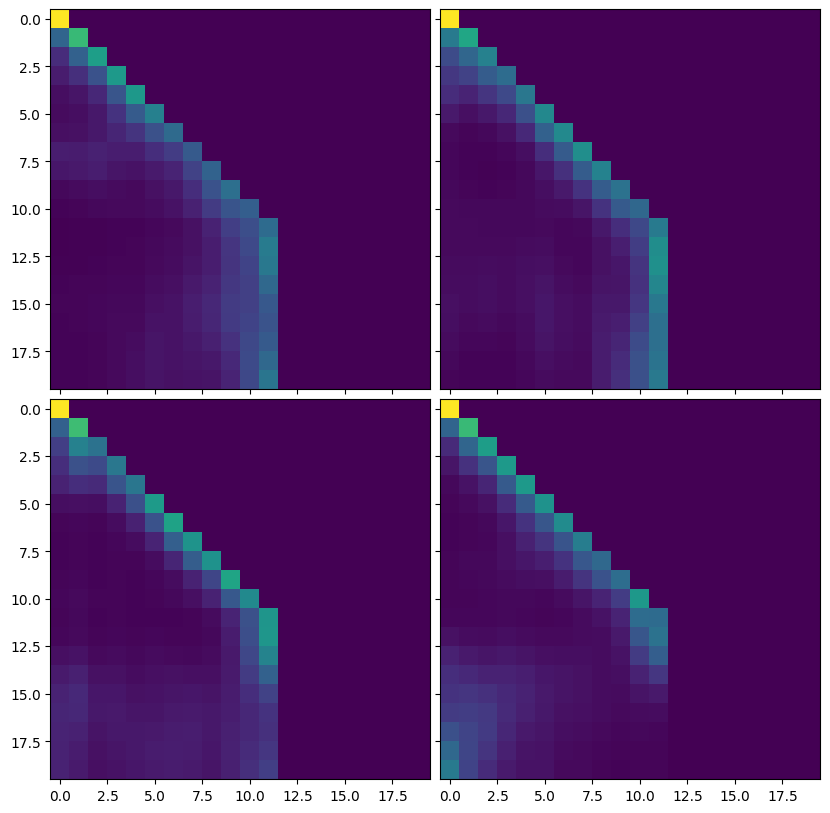

In [16]:
fig = plt.figure(figsize=(10., 10.))
# Получение весов внимания из первого блока декодера
attention_weights = model.decoder.decoder_blocks[0].self_attention.attention_weigths.detach().numpy()
images = attention_weights[0, :4]
# Создание сетки из 2x2 подграфиков
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),  # создание сетки 2x2 осей
                 axes_pad=0.1,  # отступ между осями в дюймах
                )

# Отображение изображений на подграфиках
for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

Что можно пронаблюдать?

In [ ]:
Ваш ответ = "Видна массированная структура. После 11 токена идет обрыв" # @param {type:"string"}

Давайте теперь протестируем нашу модель.

In [31]:
class Translator(nn.Module):
    def __init__(self, transformer):
        super(Translator, self).__init__()
        self.transformer = transformer

    @staticmethod
    def str_to_tokens(s):
        return [ord(z)-97+3 for z in s]

    @staticmethod
    def tokens_to_str(tokens):
        return "".join([chr(x+94) for x in tokens])

    def __call__(self, sentence, max_length=None, pad=False):
        # Преобразование строки в тензор токенов
        x = torch.tensor(self.str_to_tokens(sentence))
        x = torch.cat([torch.tensor([SOS_IDX]), x, torch.tensor([EOS_IDX])]).unsqueeze(0)

        # Получение выходов энкодера и маски
        encoder_output, mask = self.transformer.encode(x)  # (B, S, E)

        if not max_length:
            max_length = x.size(1)

        outputs = torch.ones((x.size()[0], max_length)).type_as(x).long() * SOS_IDX

        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            if output[:, -1].detach().numpy() in (EOS_IDX, SOS_IDX):
                break
            outputs[:, step] = output[:, -1]

        return self.tokens_to_str(outputs[0])

translator = Translator(model)

# Пример использования
sentence = "egorbykovegor" # Напишите любое слово
translation = translator(sentence)
print(f"Original: {sentence}")
print(f"Translated: {translation}")

Original: egorbykovegor
Translated: _rogevokybroge_


И снова отрисуем тепловую карту первого блока из декодера.

<Figure size 640x480 with 0 Axes>

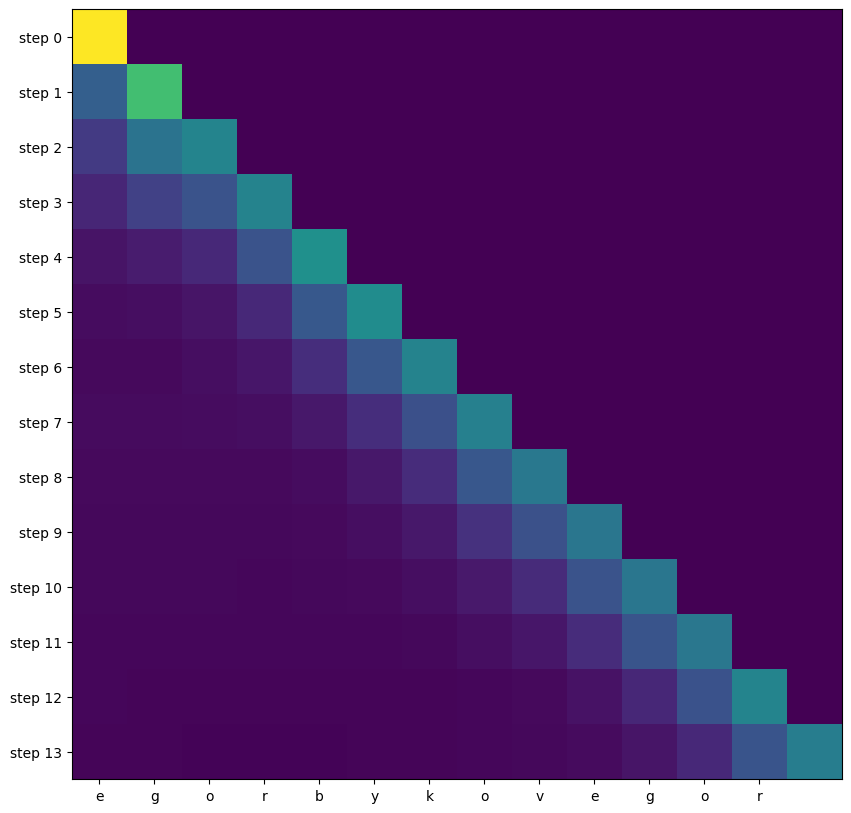

In [25]:
fig = plt.figure()

# Get attention weights from the first decoder block's self-attention
# Shape: (batch_size, num_heads, tgt_len, tgt_len)
attention_weights = model.decoder.decoder_blocks[0].self_attention.attention_weigths.detach().numpy()

# Take the first sample and average across all attention heads
images = attention_weights[0].mean(axis=0)  # Average over heads
fig, ax = plt.subplots(1,1, figsize=(10., 10.))

ax.set_yticks(range(len(translation)))
ax.set_xticks(range(len(sentence)))

ax.xaxis.set_label_position('top')

ax.set_xticklabels(iter(sentence))
ax.set_yticklabels([f"step {i}" for i in range(len(translation))])
ax.imshow(images)

Какой вывод можно сделать?

In [ ]:
Ваш ответ = "Маскированная структура" # @param {type:"string"}